In [82]:
from pandas import read_csv, DataFrame
import statsmodels.api as sm
from statsmodels.iolib.table import SimpleTable
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import r2_score
import ml_metrics as metrics
import numpy as np
import matplotlib.pyplot as plt

In [6]:
dataset = read_csv('tovar_moving.csv',';', index_col=['date'], parse_dates=['date'], dayfirst=True)
dataset.head(15)

,qty
date,
2009-09-01,179667
2009-09-02,177670
2009-09-03,152112
2009-09-04,142938
2009-09-05,130741
2009-09-06,195866
2009-09-07,162560
2009-09-08,175382
2009-09-09,139323


In [7]:
otg = dataset.qty
otg.head()

date
2009-09-01    179667
2009-09-02    177670
2009-09-03    152112
2009-09-04    142938
2009-09-05    130741
Name: qty, dtype: int64

<AxesSubplot:xlabel='date'>

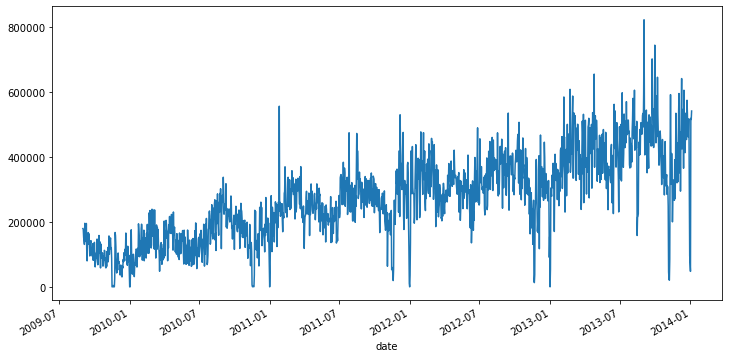

In [8]:
otg.plot(figsize=(12,6))

<AxesSubplot:xlabel='date'>

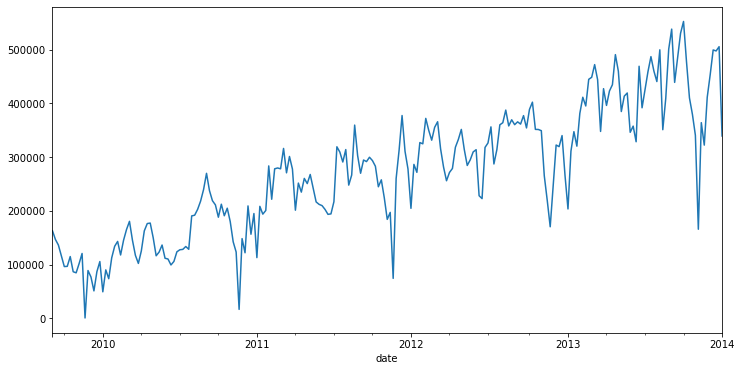

In [10]:
otg = otg.resample('W').mean()
otg.plot(figsize=(12,6))

count       227.000000
mean     271655.765261
std      119436.105049
min         872.857143
25%      180449.714286
50%      277974.857143
75%      355984.000000
max      552485.142857
Name: qty, dtype: float64

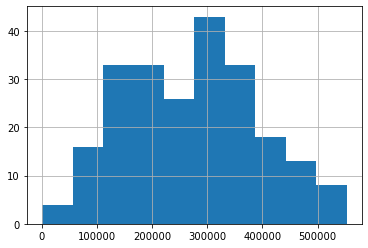

In [11]:
itog = otg.describe()
otg.hist()
itog

In [13]:
print ('V = %f' % (itog['std']/itog['mean']))

V = 0.439660


In [18]:
row =  [u'JB', u'p-value', u'skew', u'kurtosis']
jb_test = sm.stats.stattools.jarque_bera(otg)
a = np.vstack([jb_test])
itog = SimpleTable(a, row)
print (itog)

        JB             p-value               skew             kurtosis    
--------------------------------------------------------------------------
5.503693557753196 0.0638099095318595 0.10046871601796732 2.264124702091217
--------------------------------------------------------------------------


In [19]:
test = sm.tsa.adfuller(otg)
print ('adf: ', test[0])
print ('p-value: ', test[1])
print ('Critical values: ', test[4])
if test[0]> test[4]['5%']: 
    print ('есть единичные корни, ряд не стационарен')
else:
    print ('единичных корней нет, ряд стационарен')

adf:  -1.5991073472165112
p-value:  0.4840418662764224
Critical values:  {'1%': -3.461429147102264, '5%': -2.875206950587861, '10%': -2.5740544497344002}
есть единичные корни, ряд не стационарен


In [26]:
otg1diff = otg.diff(periods=1).dropna()

In [27]:
test = sm.tsa.adfuller(otg1diff)
print ('adf: ', test[0])
print ('p-value: ', test[1])
print ('Critical values: ', test[4])
if test[0]> test[4]['5%']: 
    print ('есть единичные корни, ряд не стационарен')
else:
    print ('единичных корней нет, ряд стационарен')

adf:  -5.600873017577818
p-value:  1.2656755564425138e-06
Critical values:  {'1%': -3.461878735881654, '5%': -2.875403665910809, '10%': -2.574159410430839}
единичных корней нет, ряд стационарен


In [36]:

m = otg1diff.index[len(otg1diff.index)//2+1]
r1 = sm.stats.DescrStatsW(otg1diff[m:])
r2 = sm.stats.DescrStatsW(otg1diff[:m])
print ('p-value: ', sm.stats.CompareMeans(r1,r2).ttest_ind()[1])

p-value:  0.7684168965866267


<AxesSubplot:xlabel='date'>

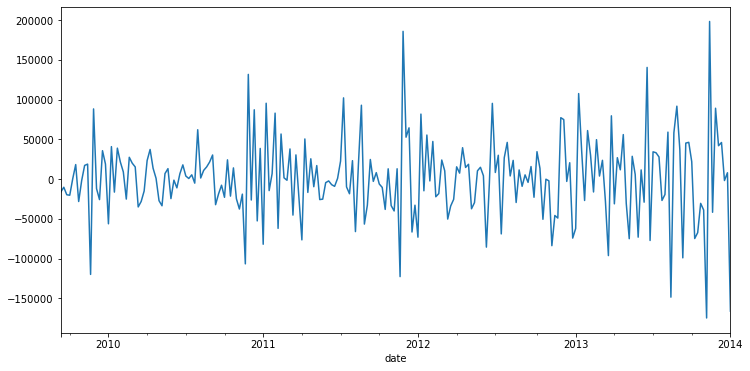

In [37]:
otg1diff.plot(figsize=(12,6))

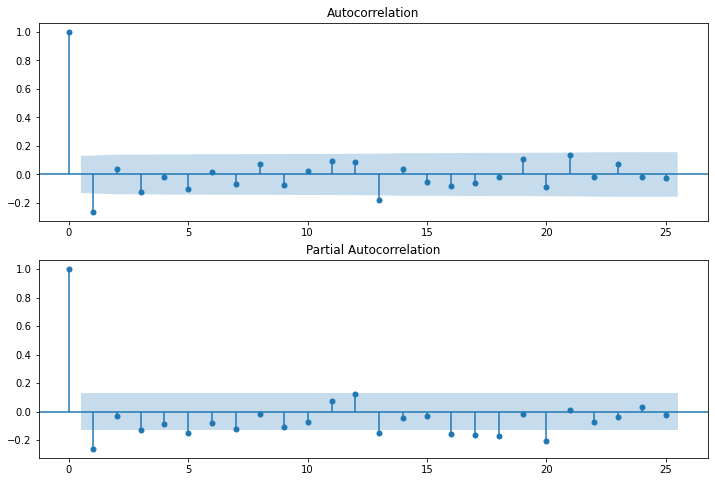

In [42]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(otg1diff.values.squeeze(), lags=25, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(otg1diff, lags=25, ax=ax2)

In [62]:
src_data_model = otg[:'2013-05-26']
model = ARIMA(src_data_model, order=(1,1,1), freq='W').fit()
print(model.summary())

                               SARIMAX Results                                
Dep. Variable:                    qty   No. Observations:                  195
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -2340.289
Date:                Sat, 04 Dec 2021   AIC                           4686.579
Time:                        15:37:22   BIC                           4696.382
Sample:                    09-06-2009   HQIC                          4690.548
                         - 05-26-2013                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6308      0.081      7.788      0.000       0.472       0.790
ma.L1         -0.9017      0.061    -14.680      0.000      -1.022      -0.781
sigma2       1.88e+09   3.42e-12   5.49e+20      0.0

In [64]:
q_test = sm.tsa.stattools.acf(model.resid, qstat=True) #свойство resid, хранит остатки модели, qstat=True, означает что применяем указынный тест к коэф-ам
print (DataFrame({'Q-stat':q_test[1], 'p-value':q_test[2]}))

       Q-stat   p-value
0    1.135960  0.286508
1    2.756436  0.252027
2    4.195563  0.241107
3    4.996936  0.287612
4    5.019929  0.413453
5    7.136820  0.308379
6    7.406535  0.387813
7    7.416572  0.492425
8    8.228012  0.511342
9    8.546713  0.575593
10   9.371377  0.587654
11   9.476535  0.661779
12  14.537403  0.337114
13  17.004088  0.255960
14  21.361727  0.125665
15  23.645305  0.097543
16  25.007022  0.094553
17  25.007170  0.124719
18  25.973688  0.130924
19  25.994696  0.165987
20  29.081612  0.112056
21  29.081672  0.142544
22  29.183558  0.174301
23  32.681153  0.110982
24  32.922510  0.133017
25  33.960067  0.136033
26  34.007279  0.165836
27  34.333428  0.190110
28  38.092884  0.120285
29  38.347481  0.141030
30  38.654989  0.162262
31  38.655145  0.194220
32  38.762598  0.225772
33  38.937946  0.257174
34  38.952081  0.296415
35  40.026098  0.296038
36  42.883119  0.233520
37  45.741849  0.181575
38  46.636469  0.187183
39  47.118197  0.204238


C:\Users\user\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:657: FutureWarning: The default number of lags is changing from 40 tomin(int(10 * np.log10(nobs)), nobs - 1) after 0.12is released. Set the number of lags to an integer to  silence this warning.
  warnings.warn(
C:\Users\user\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:667: FutureWarning: fft=True will become the default after the release of the 0.12 release of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(


In [78]:
pred = model.predict('2013-05-26','2014-12-31', typ='levels')
trn = otg['2013-05-26':]
r2 = r2_score(trn, pred[1:34])
print ('R^2: %1.2f' % r2)

R^2: -0.06


In [83]:
metrics.rmse(trn,pred[1:34])

82078.4081214544

In [84]:
metrics.mae(trn,pred[1:34])

66841.49449303786

<AxesSubplot:xlabel='date'>

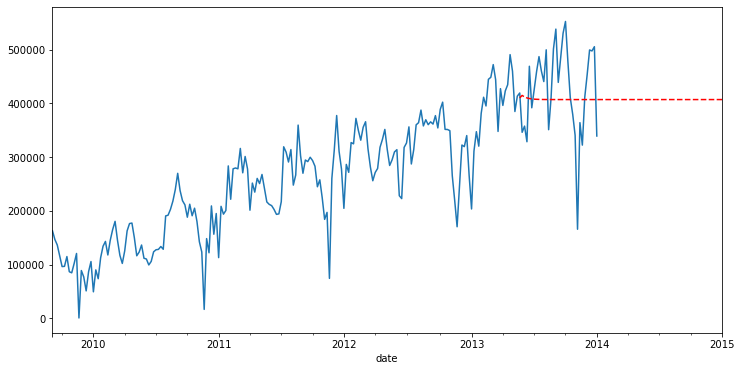

In [85]:
otg.plot(figsize=(12,6))
pred.plot(style='r--')